<h1><b>House Prices: Advanced Regression Techniques</b></h1>
<br>Predict sales prices and practice feature engineering, RFs, and gradient boosting
<br>https://www.kaggle.com/c/house-prices-advanced-regression-techniques

**Models:**
<br>Linear model
<br>Gradient boosting model
<br>Random Forests
<br>XGBoost 


<H1>1. Importing packages

In [1]:
## Importing packages
library(tidyverse) # metapackage with lots of helpful functions

library(corrplot)
library(ggplot2)
library(ggpubr)
library(gbm)
library(randomForest)
library(data.table)
library(xgboost)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1.9000     ✔ purrr   0.3.2     
✔ tibble  2.1.1          ✔ dplyr   0.8.1     
✔ tidyr   0.8.3          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
corrplot 0.84 loaded
Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

Loaded gbm 2.1.5
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

  

<h2>1.1 Definitions

In [2]:
# Evaluation metric function
RMSE <- function(x,y){
    a <- round(sqrt(sum((log(x)-log(y))^2)/length(y)),5)
    return(a)
}

#Find outliers
findOutlier <- function(data, cutoff = 8) {
    #Calculate the sd
    sds <- apply(data, 2, sd, na.rm = TRUE)
    # Identify the cells with value greater than cutoff * sd (column wise)
    result <- mapply(function(d, s) {
        which(d > cutoff * s)
    }, data, sds)
    result
}

#Remove outliers
removeOutlier <- function(data, outliers) {
    result <- mapply(function(d, o) {
        res <- d
        res[o] <- NA
        return(res)
    }, data, outliers)
    return(as.data.frame(result))
}

#Convert categorical variable to numeric
categoricalToNumeric <- function(data){
    must.convert <- sapply(data ,is.factor)        #variable needs to be displayed as numeric    
    data.aux<-sapply(data[,must.convert],unclass)  #data.frame of all categorical variables to convert   
    data.out<-cbind(data[,!must.convert],data.aux) #complete data.frame with all variables    
    return(data.out)    
}

<h1>2. Importing Data

In [3]:
df.data <- read.csv('../input/train.csv')
df.test <- read.csv('../input/test.csv')

# Set seed so the train/test split is reproducible
set.seed(42)

df.train.split <- sample(2
                        , nrow(df.data)
                        , replace = TRUE
                        , prob = c(0.85, 0.15))
df.train = df.data[df.train.split == 1,]
df.val   = df.data[df.train.split == 2,]

paste('Length Training Set: ',nrow(df.train),'| Length Validation Set: ',nrow(df.val),'| Length Test Set: ',nrow(df.test))

[1] "Length Training Set:  1247 | Length Validation Set:  213 | Length Test Set:  1459"

<h2>2.1 Data prep

In [4]:
#Encode character features as numeric
df.train <- categoricalToNumeric(df.train)
df.val <- categoricalToNumeric(df.val)
df.test <- categoricalToNumeric(df.test)

#Set NA's to 0
df.train[is.na(df.train)] <- 0
df.val[is.na(df.val)]     <- 0
df.test[is.na(df.test)]   <- 0

<h2>2.2 Feature Engineering

In [5]:
df.train$remodeled <- ifelse(df.train$YearRemodAdd - df.train$YearBuilt > 0, 1, 0)
df.val$remodeled   <- ifelse(df.val$YearRemodAdd   - df.val$YearBuilt   > 0, 1, 0)
df.test$remodeled  <- ifelse(df.test$YearRemodAdd  - df.test$YearBuilt  > 0, 1, 0)

#Total age
df.train$age <- ifelse(df.train$YearRemodAdd - df.train$YearBuilt > 0, df.train$YrSold - df.train$YearRemodAdd, df.train$YrSold - df.train$YearBuilt)
df.val$age   <- ifelse(df.val$YearRemodAdd   - df.val$YearBuilt   > 0, df.val$YrSold   - df.val$YearRemodAdd, df.val$YrSold     - df.val$YearBuilt)
df.test$age  <- ifelse(df.test$YearRemodAdd  - df.test$YearBuilt  > 0, df.test$YrSold  - df.test$YearRemodAdd, df.test$YrSold   - df.test$YearBuilt)

#Garage age
df.train$garage_age <- df.train$YrSold - df.train$GarageYrBlt
df.val$garage_age   <- df.val$YrSold   - df.val$GarageYrBlt
df.test$garage_age  <- df.test$YrSold  - df.test$GarageYrBlt

#Aggregating the areas of both floors
df.train$space <-  df.train$X2ndFlrSF + df.train$X1stFlrSF
df.val$space   <-  df.val$X2ndFlrSF   + df.val$X1stFlrSF
df.test$space  <-  df.test$X2ndFlrSF  + df.test$X1stFlrSF

# Relation bettween 1st and 2nd floor
df.train$sec <- df.train$X2ndFlrSF / df.train$X1stFlrSF
df.val$sec   <- df.val$X2ndFlrSF   / df.val$X1stFlrSF
df.test$sec  <- df.test$X2ndFlrSF  / df.test$X1stFlrSF

#Total number of bathrooms
df.train$totbath <- df.train$FullBath + df.train$HalfBath + df.train$BsmtFullBath + df.train$BsmtHalfBath
df.val$totbath   <- df.val$FullBath   + df.val$HalfBath   + df.val$BsmtFullBath   + df.val$BsmtHalfBath
df.test$totbath  <- df.test$FullBath  + df.test$HalfBath  + df.test$BsmtFullBath  + df.test$BsmtHalfBath

#Relation bettween the number of bathrooms and rooms
df.train$bathRoomRel <-  df.train$TotRmsAbvGrd / df.train$totbath
df.val$bathRoomRel   <-  df.val$TotRmsAbvGrd   / df.val$totbath
df.test$bathRoomRel  <-  df.test$TotRmsAbvGrd  / df.test$totbath

<h1>3. Model fit and predict


<h2>3.1 Formula with significant features

In [6]:
#Remove Id
col.names <- colnames(df.train)
col.names <- col.names[col.names != c('Id','SalePrice')]

#Formula
fmla <- as.formula(paste("SalePrice ~ ", paste(col.names, collapse= "+")))

<h2>3.2 Linear (base line)

In [7]:
#Model fit and Predict
model.BaseLine = lm(formula = fmla, data = df.train)
predict.BaseLine <- predict(model.BaseLine,df.val)

#RMSE(root mean squared error)
rmse.BaseLine <- RMSE(df.val$SalePrice, predict.BaseLine)
paste('Base line RMSE: ',rmse.BaseLine)

Warning message in predict.lm(model.BaseLine, df.val):
“prediction from a rank-deficient fit may be misleading”

[1] "Base line RMSE:  0.14631"

<h2>3.3 Gradient Boosting

In [8]:
#Model fit and Predict
model.gbm <- gbm(formula = fmla, data = df.train, distribution = "laplace",
              shrinkage = 0.05,
              interaction.depth = 6,
              bag.fraction = 0.66,
              n.minobsinnode = 1,
              cv.folds = 100,
              keep.data = F,
              verbose = F,
              n.trees = 300)
predict.gbm <- predict(model.gbm, df.val, n.trees = 300)

#RMSE(root mean squared error)
rmse.gbm <- RMSE(df.val$SalePrice, predict.gbm)
paste('Gradient Boostgin RMSE: ',rmse.gbm)

[1] "Gradient Boostgin RMSE:  0.11847"

<h2>3.4 Random Forests

In [9]:
model.rf <- randomForest(formula = fmla, data = df.train, method = "anova",
                      ntree = 300,
                      mtry = 26,
                      replace = F,
                      nodesize = 1,
                      importance = T)
predict.rf <- predict(model.rf, df.val)

#RMSE(root mean squared error)
rmse.rf <- RMSE(df.val$SalePrice, predict.rf)
paste('Random Forest RMSE: ',rmse.rf)

[1] "Random Forest RMSE:  0.1382"

<h2>3.5 XGBoost

In [10]:
#Training with xgboost - gives better scores than 'rf'
trn.control <- trainControl(method = "cv", number = 7)

#Explore different hyperparameter values
#tune.grid <- expand.grid(nrounds=c(100,200,300,400), 
#                         max_depth = c(2:10),
#                         eta = c(0.01, 0.02, 0.05, 0.5),
#                         gamma = c(0.01),
#                         colsample_bytree = c(0.75),
#                         subsample = c(0.50),
#                         min_child_weight = c(0))


tune.grid <- expand.grid(nrounds = 400,
                        max_depth = 4,
                        eta = 0.05,
                        gamma = 0.01,
                        colsample_bytree = 0.75,
                        min_child_weight = 0,
                        subsample = 0.5)

model.xgb <- train(SalePrice ~., data = df.train[-1], method = "xgbTree",
                trControl=trn.control,
                tuneGrid = tune.grid,
                tuneLength = 10)

model.xgb

eXtreme Gradient Boosting 

1247 samples
  86 predictor

No pre-processing
Resampling: Cross-Validated (7 fold) 
Summary of sample sizes: 1068, 1068, 1069, 1070, 1069, 1068, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  27768.95  0.8787271  15635.16

Tuning parameter 'nrounds' was held constant at a value of 400
Tuning
 held constant at a value of 0
Tuning parameter 'subsample' was held
 constant at a value of 0.5

In [11]:
predict.xgb <- predict(model.xgb, df.val[-1])

#RMSE(root mean squared error)
rmse.xgb <- RMSE(df.val$SalePrice, predict.xgb)
paste('XGBoost RMSE: ',rmse.xgb)

[1] "XGBoost RMSE:  0.11601"

<h1>4. Evaluate Model

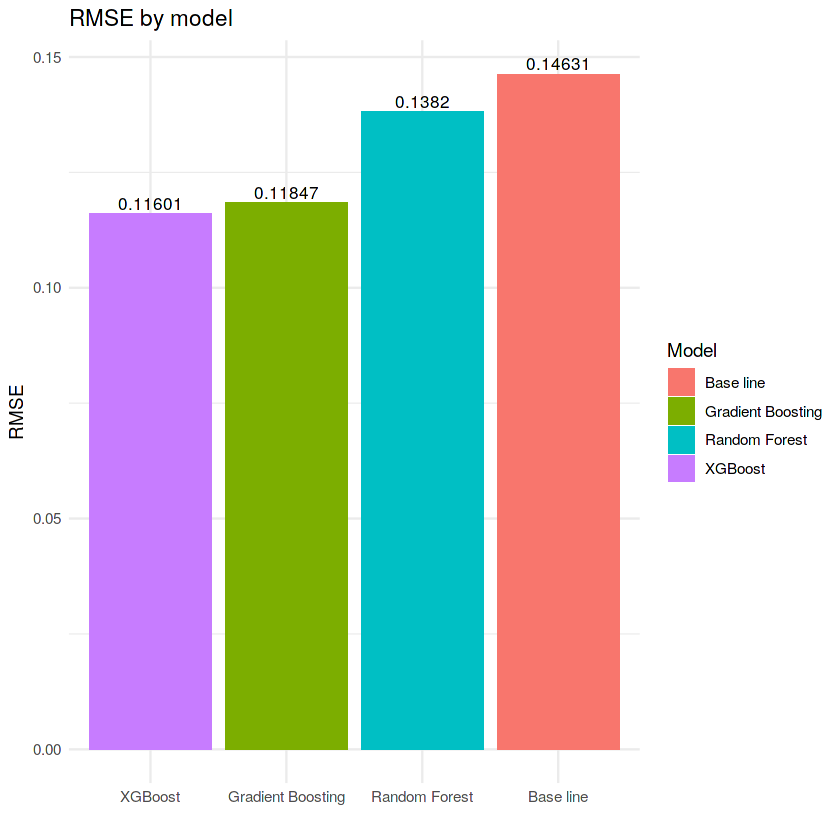

In [12]:
df.rmse <- data.frame("Model" = c("Base line","Gradient Boosting", "Random Forest", "XGBoost"),
                     "RMSE" = c(rmse.BaseLine, rmse.gbm, rmse.rf, rmse.xgb))

 ggplot(df.rmse, aes(x = reorder(Model,RMSE), y = RMSE)) +
    geom_text(aes(label=RMSE), vjust=-0.3, size=3.5) + 
    theme_minimal() + 
    geom_bar(aes(fill = Model), stat="identity") +
    ggtitle("RMSE by model") + xlab("")

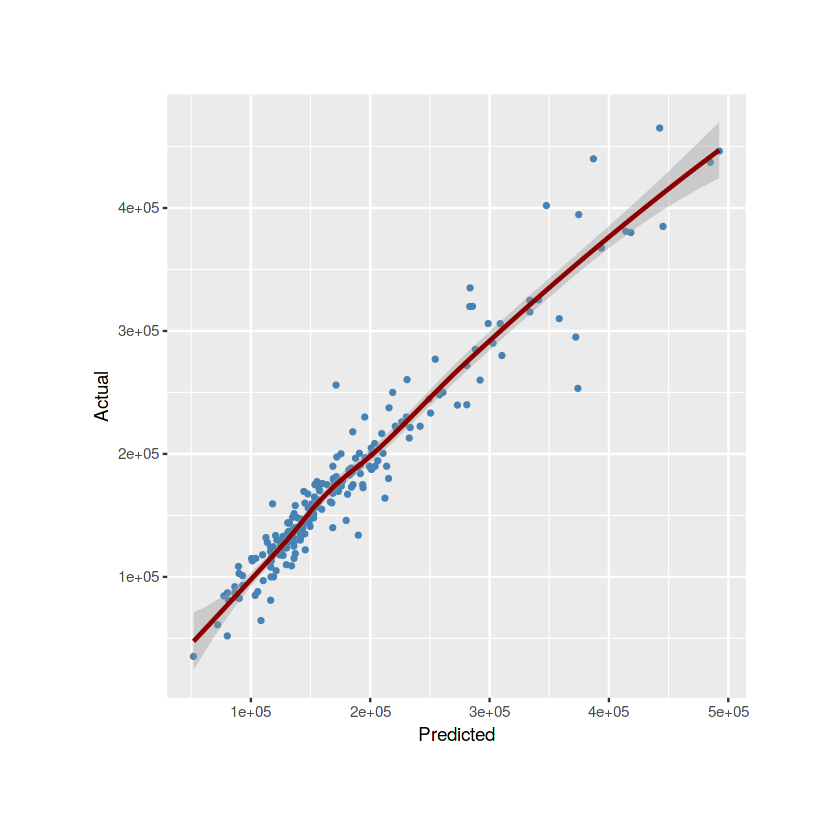

In [13]:
model.best   <- model.xgb
predict.best <- predict.xgb

ggplot(df.val,aes(x=predict.best,y=SalePrice))+
  geom_point(size=1 , color = "steelblue")+
  geom_smooth(method = "loess", color="darkred")+
  labs(x="Predicted", y="Actual")+
  theme(plot.margin = unit(c(2,2,2,2), "cm"))

<h1>5. Submission file

In [14]:
#Predict
predict.Test <- predict(model.best,df.test)

#Join ID and Predict(SalePrice)
df.kaggle.submit <-cbind(df.test["Id"],predict.Test)
colnames(df.kaggle.submit) <- c("Id", "SalePrice")

head(df.kaggle.submit)

#Submission File
write.csv(df.kaggle.submit, file = 'submission.csv', row.names=FALSE)

Id,SalePrice
<int>,<dbl>
1461,129231.7
1462,158554.7
1463,185096.3
1464,187120.2
1465,193797.5
1466,174210.8
